# **CLASSIFYING EPITOPE TYPES**

# **Task 1**

## **Introduction**

Linear B-cell eptopes are short protein fragments that are recognised by certain components of the immune system. The identification of these linear B-cell epitopes by the components of the immune system is often an important early step in the development of diagnostic tests, vaccines and therapeutic drugs for the prevention and treatment of various infectious diseases, allergies and some cancers. 

However, the process involved in the experimental discovery of these epitopes is often challenging and expensive and as a result, requires a simpler and efficient method. One of such methods, the computational methods, have been employed for the past three decades to make the process considerably more efficient by helping to prioritise candidates for characterisation in the lab. One recent development is the use of predictive models, mainly machine learning models, to classify a specific type of linear B-cell epitope[1-3].

In this report, a machine learning model is developed to classify linear B-cell epitope types using a large dataset of linear B-cell epitope proteins. It is aimed that this model will be used to predict new and unknown epitopes.

## **Data**
The dataset to use is a epitope data of different epitopes from related viruses of the Alphavirus, a genus of mosquito-borne viruses that includes various other pathogens and viruses such as the Chikungunya that affect millions of people, mainly in the Global South but with the potential to migrate northwards because of climate change. 

The dataset was created by parsing and consolidating data retrieved from online databases IEDB, Genbank and UniProtKB. This epitope data will be used to predict unknown epitopes of the Alphavirus which has relatively few known epitopes. Dataset contains 1293 features extracted from the online databases, with 11 info features describing each observation.

## **Exploratory Data Analysis**
The following steps will be taken in this section to explore the dataset. This will enable me understand the dataset and think of the various preprocessing techniques to undertake to prepare data for data modelling. Here, we will check for the data types of the features, check for missing values, duplicate rows, outliers, distribution of the epitope class, visualise the distribution of some of the extracted features, and the whole dataset. Because this data is a high-dimensional data, a clustering technique will be done to understand the optimal number of clusters to get from the features. Also, Principal Component Analysis (PCA) will be done to visualise the whole data into a 2-dimensional space. Data Exploration will be mainly done on the extracted protein data

Firstly, we will import the dataset and the various packages that will be used. 

In [ ]:
path = '/content/drive/MyDrive/Freelancing/cannybrains'

In [ ]:
import os
os.chdir(path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import robust_scale, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from tqdm import tqdm
import gc

In [ ]:
%matplotlib inline

In [ ]:
train = pd.read_csv('df_training_level1.csv', low_memory=False)
holdout = pd.read_csv('df_holdout.csv', low_memory=False)

In [ ]:
train.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,CAA51871.1:2,12161,CAA51871.1,685,S,11458006,60725,10000000,2,0,...,0.178513,-0.257270,-0.153925,0.014767,-1.294921,-0.112832,0.260342,0.123651,0.159365,0.172829
1,CAA51871.1:2,12161,CAA51871.1,686,R,11458006,60725,10000000,2,0,...,0.539347,-0.173580,-0.122266,0.235858,-1.230598,-0.060592,0.160817,0.310983,0.146951,0.240393
2,CAA51871.1:2,12161,CAA51871.1,687,L,11458006,60725,10000000,2,0,...,0.224537,-0.165938,-0.125078,0.131652,-1.359426,0.020718,0.160984,0.189219,0.204018,0.336321
3,CAA51871.1:2,12161,CAA51871.1,688,L,11458006,60725,10000000,2,0,...,0.173186,-0.069608,-0.133053,0.043285,-1.559416,-0.032758,0.099643,0.117604,0.112384,0.367813
4,CAA51871.1:2,12161,CAA51871.1,689,E,11458006,60725,10000000,2,0,...,0.136331,-0.068715,0.032138,0.099051,-1.643639,-0.199724,0.076023,-0.128873,0.127291,0.278798


In [ ]:
holdout.head(3)

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,P09592.2:2,11038,P09592.2,335,S,7543231,61574,"10000630,10000000,9796,10090",16,1,...,0.184423,-0.365618,0.010080,0.096566,-0.960775,-0.156839,0.158392,0.048518,0.281166,-0.032484
1,P09592.2:2,11038,P09592.2,336,T,7543231,61574,"10000630,10000000,9796,10090",16,1,...,0.226971,-0.114832,0.164078,0.130090,-0.612997,-0.238846,0.119155,0.057558,0.407512,0.249497
2,P09592.2:2,11038,P09592.2,337,E,7543231,61574,"10000630,10000000,9796,10090",16,1,...,0.043181,-0.020107,0.116864,0.209473,-1.431582,-0.267069,0.189000,-0.132716,0.095953,0.226894


In [ ]:
# converting variable names to lower case and remove spaces in between names
train.columns = train.columns.str.lower().str.replace('\s+', '_', regex=True)
holdout.columns = holdout.columns.str.lower().str.replace('\s+', '_', regex=True)

In [ ]:
# checking for the dimensions of train and holdout datasets
train.shape, holdout.shape

((746, 1294), (2041, 1293))

- Training data contains 746 observations (epitopes) and 1294 variables while validation (holdout) data contains 2,041 observations with 1293 variables (without the class)

__Checking for missing values and duplicate rows__

In [ ]:
# checking for missing values and duplicate rows
def checking_missing_values(df, df_name='train'):
  missing_info = pd.DataFrame()
  missing = df.isnull().sum()
  missing = missing[missing > 0]
  missing_info.index = missing.index

  # duplicate rows
  num_duplicate = len(df) - len(df.drop_duplicates())

  if len(missing) > 0:
    missing_info = missing_info.assign(counts = missing.values, 
                                       perc = missing.values/len(df)*100)
    
    missing_info.plot.hist(y='counts')
  print(f'There are {len(missing)} variables with missing values and {num_duplicate} duplicate rows in the {df_name} dataset.')

In [ ]:
checking_missing_values(train.filter(like='feat'), 'train')
checking_missing_values(holdout.filter(like='feat'), 'holdout')

There are 0 variables with missing values and 0 duplicate rows in the train dataset.
There are 0 variables with missing values and 14 duplicate rows in the holdout dataset.


- There are no variables with missing values or duplicate rows in the train data
- There are no variables with missing values in the validation data and 14 duplicate rows. This duplicate rows won't be dropped since the dataset won't be used for model development

__Checking for data types__

In [ ]:
# checking for data types
def check_data_types(df):
  dtypes = df.dtypes
  print(dtypes.value_counts())

In [ ]:
check_data_types(train)

float64    1280
object       10
int64         4
dtype: int64


In [ ]:
check_data_types(holdout)

float64    1280
object       10
int64         3
dtype: int64


- The extracted protein features are in their appropriate data types in both the train and validation datasets

__Number of Epitopes in datasets__

In [ ]:
print('There are {} epitopes in the train data'.format(train.info_epitope_id.nunique()))
print('There are {} epitopes in the holdout data'.format(holdout.info_epitope_id.nunique()))

There are 232 epitopes in the train data
There are 233 epitopes in the holdout data


__Epitope info types__

In [ ]:
train.info_type.unique()

array(['Exact Epitope',
       'Exact Epitope,Epitope containing region/antigenic site',
       'Epitope containing region/antigenic site,Exact Epitope',
       'Epitope containing region/antigenic site'], dtype=object)

In [ ]:
holdout.info_type.unique()

array(['Epitope containing region/antigenic site',
       'Exact Epitope,Epitope containing region/antigenic site',
       'Epitope containing region/antigenic site,Exact Epitope',
       'Exact Epitope'], dtype=object)

- There are 4 epitope info types in both train and validation data

__Class Distribution__

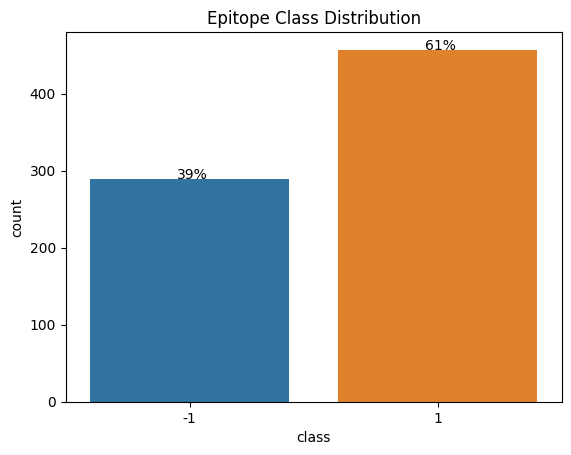

In [ ]:
ax = sns.countplot(x='class', data=train)
plt.title('Epitope Class Distribution')

for i in ax.patches:
  perc = i.get_height()/len(train)*100
  plt.text(i.get_x()+0.35, i.get_height()+0.3, f'{perc:.0f}%')
plt.show()

In [ ]:
train['class'].value_counts()

 1    457
-1    289
Name: class, dtype: int64

- There is an imbalance in the target class distribution. About 61% belong to the class 1 type while 39% are in class -1.

- We will balance the class -1 distribution to match up with that of class 1

In [ ]:
train.info_cluster.value_counts()

204    516
298     69
229     54
320     42
199     30
215     20
264      8
256      7
Name: info_cluster, dtype: int64

In [ ]:
train.groupby(['class', 'info_cluster'])['class'].count().unstack()

info_cluster,199,204,215,229,256,264,298,320
class,,,,,,,,
-1,NaN,289.0,NaN,NaN,NaN,NaN,NaN,NaN
1,30.0,227.0,20.0,54.0,7.0,8.0,69.0,42.0


- Only _info_cluster 204_ have observations belonging to class -1 (minority class)

__Summary Statistics of extracted features__

In [ ]:
def get_summary_statistics(df):
  summary = df.describe()
  skew = df.skew()
  kurt = df.kurtosis()
  range_ = df.max() - df.min()
  iqr = df.quantile(0.75) - df.quantile(0.25)
  summary.loc['skewness', :] = skew.values
  summary.loc['kurtosis', :] = kurt.values
  summary.loc['range', :] = range_.values
  summary.loc['IQR', :] = iqr.values
  return summary

In [ ]:
# get summary statistics for train dataset
get_summary_statistics(train.filter(like='feat'))

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,...,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,0.081334,0.155190,0.045183,0.093532,-0.187883,-0.079048,0.002961,-0.013465,-0.093546,0.045785,...,0.082458,-0.026580,-0.052922,0.130508,-0.912585,-0.068948,0.098828,-0.005770,0.026254,0.234138
std,0.134752,0.135894,0.153447,0.126711,0.150018,0.171420,0.171293,0.189475,0.146342,0.127296,...,0.149778,0.133427,0.138832,0.141839,0.326053,0.151345,0.151581,0.145622,0.148122,0.159960
min,-0.605968,-0.368321,-0.453714,-0.270026,-0.623107,-0.587313,-0.546888,-0.428600,-0.537224,-0.508726,...,-0.252364,-0.426012,-0.438437,-0.298351,-1.749543,-0.402438,-0.344357,-0.456177,-0.401215,-0.326890
25%,-0.005342,0.056017,-0.045173,0.007387,-0.283482,-0.200325,-0.115509,-0.157970,-0.188088,-0.047907,...,-0.025213,-0.118891,-0.141919,0.036957,-1.142586,-0.176104,0.003478,-0.091283,-0.083311,0.135777
50%,0.093366,0.159134,0.050690,0.102058,-0.190992,-0.087125,-0.000722,-0.023049,-0.095882,0.046730,...,0.070693,-0.026712,-0.052635,0.129109,-0.929380,-0.082213,0.099465,0.008209,0.022796,0.249037
75%,0.177607,0.248278,0.140758,0.177299,-0.090165,0.035861,0.120766,0.114863,0.006965,0.137709,...,0.179583,0.066112,0.049650,0.223102,-0.693119,0.009155,0.192338,0.099157,0.125548,0.340555
max,0.431492,0.533593,0.464730,0.484326,0.291663,0.476413,0.527441,0.568731,0.384280,0.433851,...,0.546722,0.349790,0.337160,0.576059,0.692667,0.447825,0.676943,0.343372,0.521267,0.624794
skewness,-0.630684,-0.128538,-0.213468,-0.156649,-0.054259,0.287775,0.009797,0.292618,0.100578,-0.144134,...,0.268479,-0.046458,-0.128713,0.127439,0.419351,0.713435,0.211590,-0.413295,0.179097,-0.401739
kurtosis,1.394731,0.253799,0.361137,-0.014820,0.043569,0.336839,-0.307746,-0.347681,0.220836,0.474572,...,-0.216880,-0.204978,-0.241675,0.113195,0.951942,0.607933,0.794472,-0.094744,-0.034263,0.072516


In [ ]:
# get summary statistics for holdout dataset
get_summary_statistics(holdout.filter(like='feat'))

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,...,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000
mean,0.032610,0.193316,0.052427,0.033001,-0.129166,-0.061671,-0.116340,-0.017092,-0.176566,-0.068693,...,0.180432,-0.101634,-0.040501,-0.004456,-1.003079,-0.193473,-0.047060,0.026982,0.092908,0.289571
std,0.138901,0.126487,0.142380,0.119783,0.140751,0.141590,0.135585,0.191922,0.133207,0.140209,...,0.145766,0.135784,0.130957,0.146404,0.335217,0.135263,0.144571,0.129350,0.148199,0.144848
min,-0.456280,-0.301894,-0.521566,-0.424652,-0.814084,-0.750982,-0.530544,-0.737656,-0.900567,-0.653730,...,-0.704516,-0.482586,-0.473047,-0.585977,-1.866610,-0.623356,-0.528397,-0.479999,-0.599979,-0.624933
25%,-0.053730,0.119149,-0.042857,-0.048496,-0.225907,-0.149865,-0.209199,-0.158577,-0.262250,-0.154713,...,0.085822,-0.197326,-0.131992,-0.088030,-1.219444,-0.281443,-0.144670,-0.048192,-0.009962,0.198870
50%,0.034878,0.204084,0.052460,0.029545,-0.131671,-0.057013,-0.113586,-0.030437,-0.178426,-0.058567,...,0.184423,-0.099070,-0.041885,0.007311,-1.041196,-0.197088,-0.044711,0.040578,0.099329,0.281721
75%,0.118494,0.278142,0.147045,0.115535,-0.031922,0.032642,-0.023316,0.115902,-0.090890,0.024193,...,0.280498,-0.005028,0.047470,0.090209,-0.851745,-0.108986,0.044928,0.111467,0.198160,0.374003
max,0.523789,0.666137,0.514897,0.449668,0.257347,0.402440,0.445271,0.604211,0.243962,0.521901,...,0.611802,0.465820,0.604553,0.519956,1.049740,0.244679,0.520583,0.499753,0.474389,0.858086
skewness,-0.083639,-0.421312,-0.046806,0.044681,-0.103655,-0.191309,0.054694,0.091481,-0.075885,-0.379245,...,-0.325893,0.023114,0.076415,-0.367169,1.239935,0.113543,0.075517,-0.559705,-0.246260,0.076534
kurtosis,0.229757,0.753217,0.199364,0.067161,0.371622,0.334129,0.089349,-0.103293,0.670184,1.036306,...,1.045960,-0.283049,0.070217,0.662065,3.356056,0.164565,0.143346,0.834813,0.045438,1.621663


__Checking for skewness of dataset__

In [ ]:
def check_distribution(df):
  skew_df = df.skew()
  kurt_df = df.kurt()
  fig, ax = plt.subplots(1,2, figsize=(12,4))
  skew_df.plot.hist(bins=30, edgecolor='white', ls='--', ax=ax[0])
  ax[0].set_title('Skewness', fontsize=10)
  ax[0].set_xlabel('Skewness')

  kurt_df.plot.hist(bins=30, edgecolor='white', ls='--', ax=ax[1])
  ax[1].set_title('Kurtosis', fontsize=10)
  ax[1].set_xlabel('Kurtosis')

  fig.suptitle('Extracted protein features skewness and kurtosis distribution', 
               fontsize=12, fontweight='bold', y=1.01)

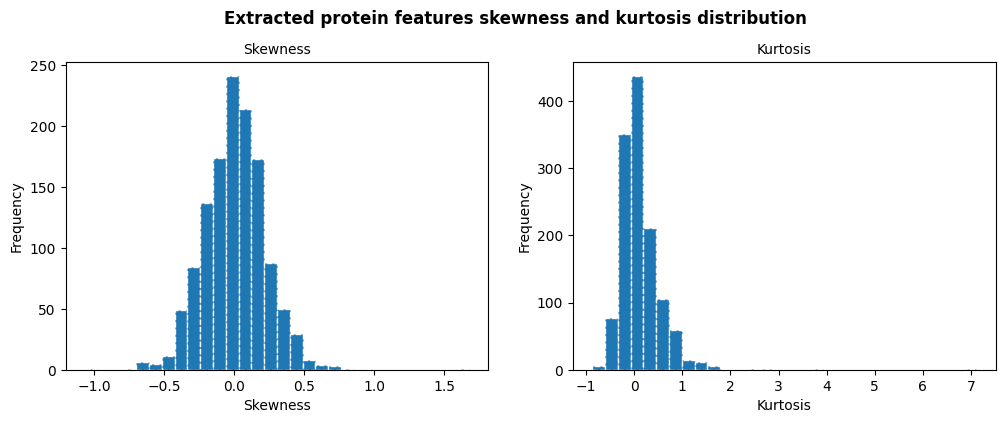

In [ ]:
# for train data
check_distribution(train.filter(like='feat'))

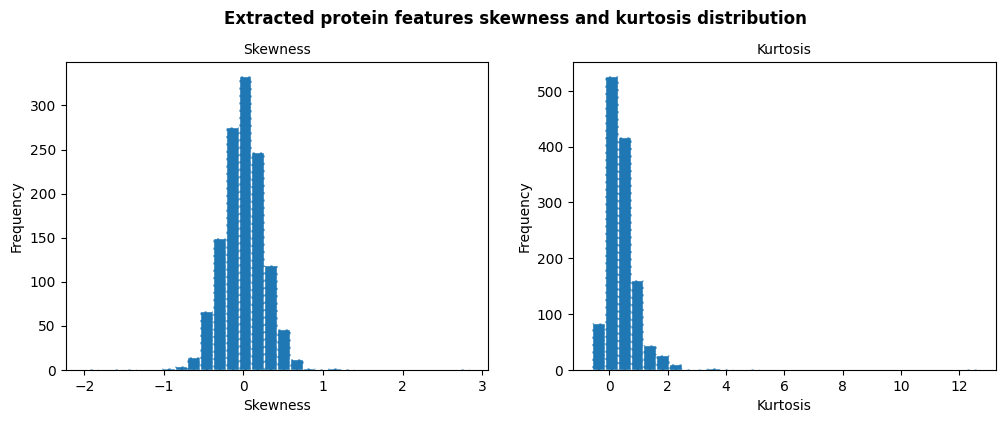

In [ ]:
# hold out
check_distribution(holdout.filter(like='feat'))

- The figures above shows the skewness and kurotis distributions of the extracted protein features. From the figure, it can be observed that the extracted protein features are both equally and unequally distributed. 
- Some extracted features are right-skewed (positive values), left-skewed (negative) while a greater percentage of them are normally or slightly normally distributed.
- Skewness varies between -1 and 1.5 while kurtosis ranges between -1 and 7
- On the other hand (right), we can see that some of the features are heavily tailed toward the right.
- There's a possible presence of outliers in some distributions where kurtosis > 3

__Checking for outliers__

From checking the kurtosis of the features, we see that there is a possible outlier present in the data. In order to check for the presence of outliers, we will use the interquartile range (IQR) method.

In [ ]:
def check_outliers(df):
  """Checks variables with outliers in them
  """
  outlier_columns = []
  temp = df.copy()
  mean = temp.mean()
  std = temp.std()

  zscores = np.abs((temp - mean) /std)
  condition  = zscores > 3 # outlier condition

  # outliers in each column
  outlier_counts_per_variable = condition.sum(axis=0)
  
  # select variables with outlier numbers greater than 0
  num_outlier_columns = np.sum(outlier_counts_per_variable > 0)
  
  # get their names
  outlier_columns = outlier_counts_per_variable[outlier_counts_per_variable > 0].index

  print(f'There are {len(outlier_columns)} variables with outliers in the dataset.')

  # number of rows to be removed as outliers
  print(f'{condition.any(axis=1).sum()} rows will be removed as outliers')

In [ ]:
check_outliers(train.filter(like='feat'))

There are 1053 variables with outliers in the dataset.
551 rows will be removed as outliers


- Using the Zscore statistical method, 1053 features were identified to contain outliers in them. This will cause 551 out of the 764 observations to be removed. As a result, an alternative method will be used. 
- In the data preprocessing section, these outliers will be treated using the trimming method, where values beyond the -3 and +3 of the ZScores will be trimmed at -3 or +3 depending on the value.

__Visualising distribution of some variables__

In this section, we will visualise the distribution of some of the extracted protein feature. Because there are over 1200 of them, we will randomly select 9 of them to visualise their distributions for both target class. The boxplot visualisation will be used here.

In [ ]:
predictors = train.filter(like='feat').columns
np.random.seed(10)
columns = np.random.choice(predictors, size=9, replace=False)

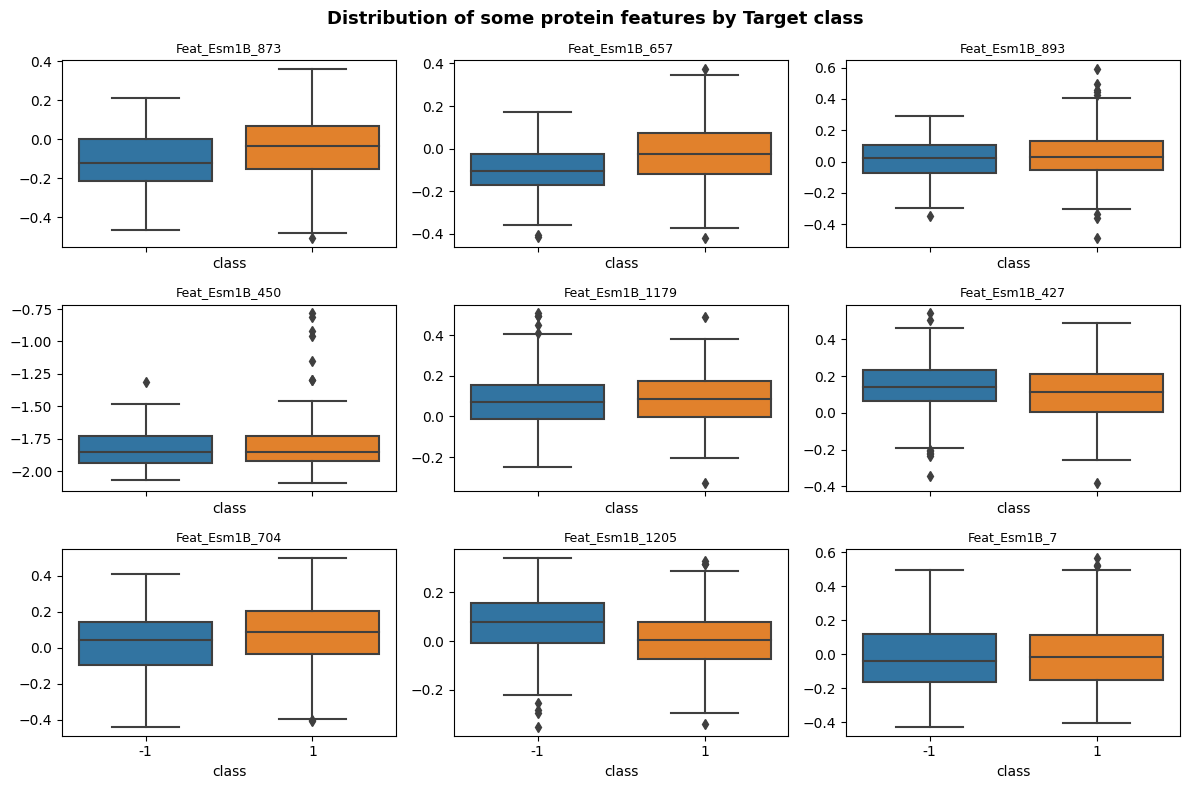

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(12,8), sharex=True)

i = 0
for row in range(3):
  for col in range(3):
    sns.boxplot(data=train, x='class', y=columns[i], ax=ax[row, col])
    ax[row, col].set(ylabel='')
    ax[row, col].set_title(columns[i].title(), fontsize=9)
    i += 1

fig.suptitle('Distribution of some protein features by Target class', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

__Clustering__

Finding the number of clusters in our dataset. Here, we will group the protein features into clusters. A hierarchical clustering method will be applied to visualise the observations in a visual format. Before clustering, the features will be scaled using the _robust_scale_ function from Scikit-Learn. This will be used to scale the features into similar scales. After that, we will draw a dendrogram to visualise the hierarchical clusters

In [ ]:
def hierarchical_clustering(df, scale_data=True):
  if scale_data:
    temp = robust_scale(df)
  else:
    temp = df.copy()

  # plot dendrogram
  plt.figure(figsize=(10, 6))  
  plt.title("Dendrograms for Extracted Protein Features")  
  linkage = shc.linkage(temp, method='ward')
  dendrogram = shc.dendrogram(linkage)
  # shc.cut_tree(Z=linkage)
  plt.xlabel('Observations')
  plt.ylabel('Height')
  plt.axhline(200, ls='--', color='black', lw=0.8)

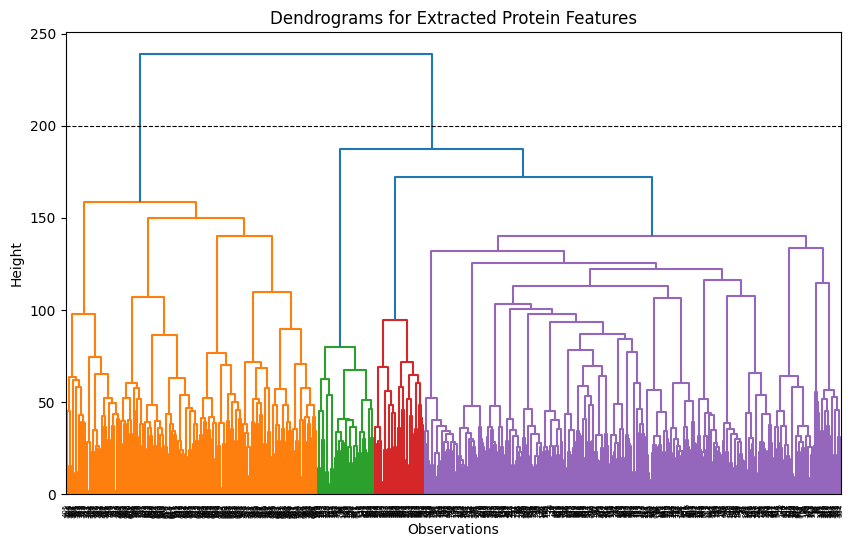

In [ ]:
hierarchical_clustering(train[predictors])

- The figure above shows a dendrogram of the observations clustered in a hierarchical order. From the chart we see that 4 clusters are formed : two big and small clusters. The smaller two clusters can be decomposed into the cluster with purpule colour, at a height of 200.
- The number of clusters (2) is similar to the number of categories in the target class

__Visualisation in Two Dimensions__

In [ ]:
def plot_data_in_2D(df):
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(scale(df))

  # plot data
  plt.figure(figsize=(9,5))
  sns.scatterplot(x=pca_data[:, 0], y=pca_data[:,1], hue=train['class'], palette='Set2')
  plt.title('Extracted Protein data in Two-Dimensions using PCA')
  plt.ylabel('Principal Component 2')
  plt.xlabel('Principal Component 1')
  
  # Boxplot
  fig, ax = plt.subplots(1,2, figsize=(8,4))
  sns.boxplot(x=train['class'], y=pca_data[:, 0], ax=ax[0])
  sns.boxplot(x=train['class'], y=pca_data[:, 1], ax=ax[1])
  ax[0].set(title='PC1 vs Target class', ylabel='PC1')
  ax[1].set(title='PC2 vs Target class', ylabel='PC2')
  fig.tight_layout()
  plt.show()

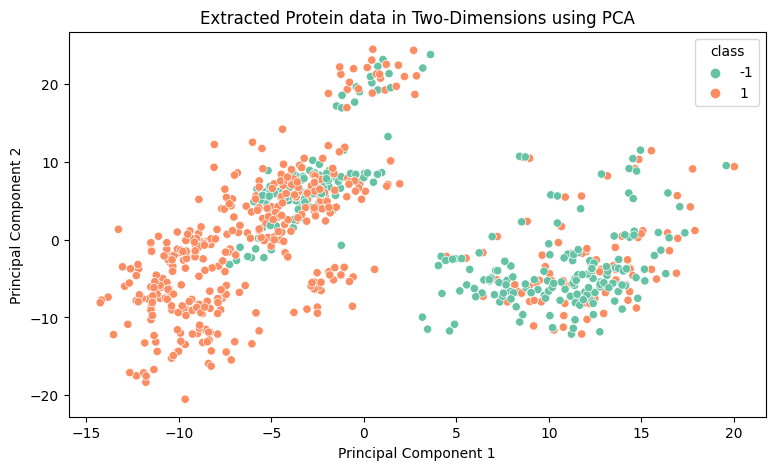

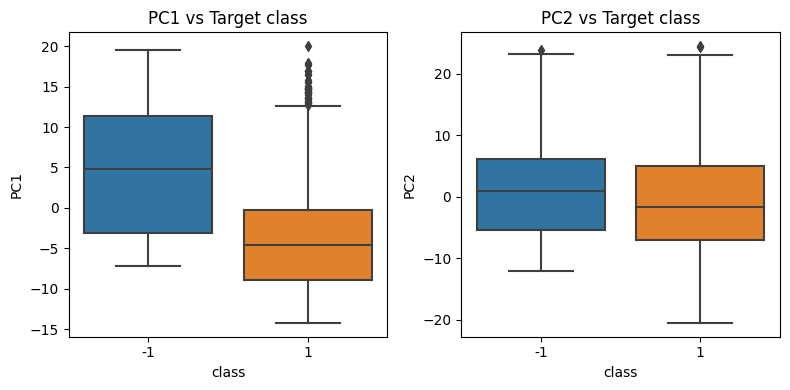

In [ ]:
plot_data_in_2D(train[predictors])

- In the scatterplot, we see that in the first component is made up of observations mostly in target class -1, while the second component consist of observations mostly in target class 1.
- In the boxplots, we can see there's a difference in the target distribution in both principal components.

__T-test statistical significance__

- Is there any statistical difference in the mean scores for each target classs at 5% level of significance?  

_Hypothesis Testing_

$H_0$ : $\mu_1 = \mu_2$

$H_1$ : $\mu_1 \not = \mu_2$

$\alpha$ : 0.05

In [ ]:
def calc_ttest(df):
  columns = df.filter(like='feat').columns
  
  pvals_ = []
  tstats_ = []

  for col in tqdm(columns):
    samp1 = df.loc[df['class'] == -1, col].dropna()
    samp2 = df.loc[df['class'] == 1, col].dropna()
    # check if there's equal variance between groups
    _, pvals = stats.levene(samp1, samp2)
    if pvals < 0.05:
      tstat, pval = stats.ttest_ind(samp1, samp2, equal_var=True)
    else:
      tstat, pval = stats.ttest_ind(samp1, samp2, equal_var=False)
      
    pvals_.append(pval)
    tstats_.append(tstat)

  result = pd.DataFrame(index=columns)
  result = result.assign(pvalues = pvals_, 
                         Tstat = tstats_)
  result = result.sort_values('pvalues')
  return result

In [ ]:
# Calculate T-test
result = calc_ttest(train)

100%|██████████| 1280/1280 [00:02<00:00, 553.66it/s]


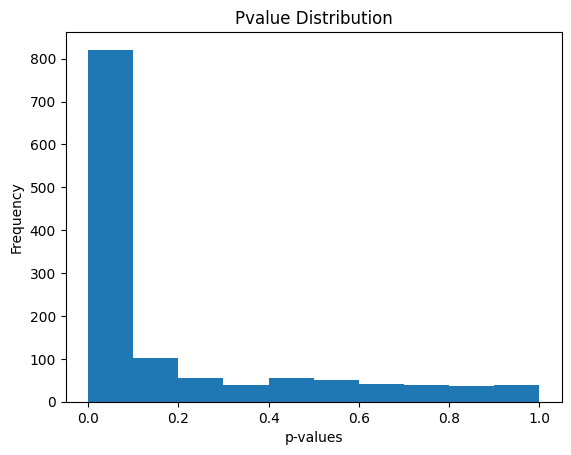

In [ ]:
result.pvalues.plot.hist(title='Pvalue Distribution')
plt.xlabel('p-values');

In [ ]:
# how many features are statistically significant?
result[result.pvalues <= 0.05].shape

(743, 2)

- There are 743 features with mean values statistically significant between target groups.
- The number of features can be reduced from 1280 to 743. However, using these 743 features will lead to higher training times. Therefore, a better approach would be to decompose all features into different principal components which capture the variability in the data at different directions.

## **Data Preprocessing**

In this section, the datasets will be preprocessed such that they are suitable for data modelling. Preprocessing steps to be taken here will be based on the anomalies discovered in the data exploration analysis. These include; the variable scaling and treatment of Outliers. 

The scaling method to be applied here would be the _standardisation_ method where the mean will be subtracted from each value for every variable. This will be done on both the training and holdout data. After that, outliers in each variable will be replaced by trimming, where values below the lower bound will be assigned the lower bound value and values above the upper bound will be assigned the upper bound value.

In [ ]:
def preprocess_data(df):
  columns = df.filter(like='feat').columns
  
  # Scale Data
  # get mean and standard deviations
  mean = np.nanmean(df[columns], axis=0)
  std = np.nanstd(df[columns], axis=0)

  scaled_data  = (df[columns] - mean) / std

  # Outlier Treatment
  for col in tqdm(columns):
    # replace values lower than -3 with -3 since -3 is the lower bound
    scaled_data.loc[scaled_data[col] < -3, col] = -3
    scaled_data.loc[scaled_data[col] > 3, col] = 3

  # adding info_cluster and class to train and info_cluster to validation
  scaled_data = scaled_data.assign(info_cluster = df.info_cluster)
  if 'class' in df.columns:
    scaled_data['class'] = df['class']
  return scaled_data

In [ ]:
# preprocess data by scaling and treating outliers
train_scaled = preprocess_data(train)

100%|██████████| 1280/1280 [00:00<00:00, 1303.12it/s]


## **Feature Reduction**

Here, the protein features will be reduced into smaller number of variables. This will enable the speedy training of models. For this section, the PCA feature extraction method will be used to decompose the 1280 protein features into uncorrelated principal components that maximise the variance in the data. These principal components are linear combination of the original dataset [4].

The number of principal components is equal to the number of variables in the data. The first principal component explains where the variance is the highest and the other components account the variance not explained by the principal components preceding them. As a result, we will select principal components where 95% of the variance in the data have been captured.[4]



In [ ]:
def pca_feature_reduction(train_df, validation_df=None, var_ratio=0.95):
  """
  Performs a PCA Feature reduction technique to select the number of 
  principal components that maximise the variability of data
  """
  columns = train_df.filter(like='feat').columns

  pca = PCA(n_components=var_ratio)
  pca.fit(train_df[columns])

  pca_train_data = pca.transform(train_df[columns])
  n_comps = pca.n_components_ # number of components returned

  # put into dataframe
  pca_train_data = pd.DataFrame(pca_train_data, columns=[f'PC{i}' for i in range(1, n_comps+1)])

  # adding info_cluster and class to train and info_cluster to validation
  pca_train_data = pca_train_data.assign(info_cluster = train_df.info_cluster)
  pca_train_data['class'] = train_df['class']

  if validation_df is not None:
    pca_val_data = pca.transform(validation_df[columns])
    pca_val_data = pd.DataFrame(pca_val_data, columns=[f'PC{i}' for i in range(1, n_comps+1)])
    pca_val_data = pca_val_data.assign(info_cluster = validation_df.info_cluster)
    return pca_train_data, pca_val_data
  else:
    return pca_train_data

In [ ]:
# reduce features
train_pca = pca_feature_reduction(train_scaled, var_ratio=0.95)

In [ ]:
train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,info_cluster,class
0,-9.050928,-1.572851,-1.351965,14.730197,5.265847,-4.359701,-0.003386,6.343897,-0.020559,-1.863657,...,-0.183777,0.485710,-0.542076,-0.616202,-0.006841,-0.707900,-0.557792,-0.176773,199,1
1,-11.538951,-0.620904,-1.976443,3.971552,-2.504912,1.834761,4.542937,0.143178,5.089616,5.075732,...,-0.387239,0.810210,-0.491430,-0.418554,-0.082737,-1.048422,-0.681446,0.209199,199,1
2,-13.722680,-7.683434,-1.512740,-7.838518,17.087478,-0.347084,-0.156692,1.273834,0.076227,-5.003027,...,0.213477,0.735708,0.158345,-0.344198,0.902874,0.227535,-0.295453,0.532432,199,1
3,-14.097290,-8.093641,-1.726898,-8.071667,16.981451,-1.027616,0.406332,1.066449,0.169797,-5.551082,...,0.416524,-0.004726,0.236516,-0.653045,0.894470,-0.536861,-0.291796,0.551944,199,1
4,-12.567879,-3.986493,1.073523,3.311133,-2.468990,0.538358,7.186006,3.987992,-4.610167,-10.302404,...,-0.616174,0.852132,1.703395,-1.165335,0.249464,-0.329323,-0.071941,-0.376472,199,1


- After PCA transformation, the number of features reduced from 1280 original features to 215 principal components which account for 95% of the variability in the data.

## **Data Rebalancing**

From the EDA (Exploratory Data Analysis), it is observed that the distribution is slightly imbalanced. To account for this imbalance, a cost-sensitive learning method will be used, where weights will be given to each class. A higher weight is given to the minority class to penalise an occurrence of  misclassification of the minority class and a lower penalty is applied when an instance in the majority class is miclassified. 

This section was be applied during modelling. Firstly, balanced weights was applied before then obtaining optimal weight ratios with the best performance on the test data based on the Area under the Receiver's Operating Characteristic curve (AUC). The _balanced_ weight takes into account the majority/minority ratio. Optimal weight was done using a grid search method during hyperparameter optimisation.

## **Modelling**

Three machine learning models (logistic regression, Random forest and XGboost) were fit to the training data and then predicted on the test data. To measure the performance of the models, the training data was split further into two sets: a train and test data where the train data was used for developing a predictive model and the performance of the model evaluated on the test data. Splitting into train and test sets was done in a stratified manner using the _info_cluster_ variable that describes the cluster each epitope belongs to.

After that, the best model was selected and further optimisation of the parameters for improved performance. Hyperparameter optimisation was done using the _Grid Search Method_. To avoid artificially inflated performance metrics due to data leakage, hyperparameter tuning was performed using a group fold split.

In [ ]:
def tune_hyperparameters(classifier, params, X, y, cv=5, groups=None):
  """Performs Hyperparameter tuning

  Parameters
  ----------
  classifier: classification model
  params : parameter grid to tune
  X: Xtrain
  y: ytrain
  cv: Number of cross validation splits
  groups: Groups to use for splitting dataset

  Returns: A fitted Grid search model
  """
  skfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=3)
  gcv = GridSearchCV(classifier, param_grid=params, scoring='roc_auc', 
                     n_jobs=7, cv=skfold, verbose=3)

  gcv.fit(X, y, groups=groups) # group kfold
  return gcv

In [ ]:
# pca features
predictors = train_pca.filter(like='PC').columns

In [ ]:
# separating into independent and target variables
X = train_pca.drop('class', axis=1)
y = train_pca['class']

In [ ]:
# pseudorandom seed for reproducibility
seed = 42

In [ ]:
# splitting data into train and test sets
# splitting will be done in a stratified method using the info_cluster
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=X['info_cluster'])

In [ ]:
xtrain.shape, xtest.shape

((634, 216), (112, 216))

In [ ]:
# getting the majority and minority class ratio in train data
ytrain.value_counts()

 1    388
-1    246
Name: class, dtype: int64

In [ ]:
# instantiating models
logistic_reg = LogisticRegression(random_state=seed, max_iter=500, C=1, class_weight={-1:0.9, 1:0.1})

rforest = RandomForestClassifier(n_estimators=500,max_depth=10, max_features=0.4, 
                                 min_samples_leaf=35, min_samples_split=2, 
                                 random_state=seed, n_jobs=6, class_weight={-1:0.5, 1:0.5})

In [ ]:
logistic_reg.fit(xtrain[predictors], ytrain)

LogisticRegression(C=1, class_weight={-1: 0.9, 1: 0.1}, max_iter=500,
                   random_state=42)

In [ ]:
rforest.fit(xtrain[predictors], ytrain)

RandomForestClassifier(class_weight={-1: 0.5, 1: 0.5}, max_depth=10,
                       max_features=0.4, min_samples_leaf=35, n_estimators=500,
                       n_jobs=6, random_state=42)

__Hyperparameter Tuning__

_Logistic Regression_

In [ ]:
# logreg_params = {
#     'class_weight' : [{-1: round(x,1), 1: round(1-x,1)} for x in np.arange(0.5,1,0.1)],
#     'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
# }

In [ ]:
# gcv = tune_hyperparameters(logistic_reg, logreg_params, xtrain[predictors], ytrain, groups=xtrain.info_cluster)

In [ ]:
# print(gcv.best_score_, gcv.best_params_)

In [ ]:
# assigning best estimator to logistic model
# logistic_reg = gcv.best_estimator_

- Using a weighted cost-sensitive learning, the optimal weight with the best performance is 0.9:0.1 minority/majority class
- Optimal C parameter is 1 with an average AUC score of 0.8924

_Random Forest_

In [ ]:
# rforest_params = {
#     'class_weight' : [{-1: round(x,1), 1: round(1-x,1)} for x in np.arange(0.5,1.,0.1)],
#     'max_depth' : [10],
#     'min_samples_leaf' : [35],
#     'min_samples_split': [2],
#     'max_features' : [0.4],
#     'n_estimators' : [500]#200, 
# }

In [ ]:
# Hyperparameter tuning for random forest
# gcv = tune_hyperparameters(rforest, rforest_params, xtrain[predictors], ytrain, groups=xtrain.info_cluster)

In [ ]:
# print(gcv.best_score_, gcv.best_params_)

In [ ]:
# assigning best random forest model
# rforest = gcv.best_estimator_

- For random forest, the weights are the same. It seems to not have issues predicting the minority class
- Optimal parameters are _{'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 35, 'min_samples_split': 2, 'n_estimators': 500}_

## **Model Assessment**

Here, the models' performance was evaluated on the test data. Similarly, to determine how the model will generalise to new, unseen data, a 5-Groupfold cross validation approach was applied. Performance is based on AUC

In [ ]:
def print_report(model, x, y):
  return print(classification_report(y, model.predict(x)))

def plot_roc_curve(model, x, y):
  auc_score = roc_auc_score(y, model.predict_proba(x)[:,1])
  print('ROC_AUC_Score: {:.4f}'.format(auc_score))
  RocCurveDisplay.from_estimator(model, x, y, pos_label=-1);

_Logistic Regression Performance_

In [ ]:
print_report(logistic_reg, xtest[predictors], ytest)

              precision    recall  f1-score   support

          -1       0.70      0.81      0.75        43
           1       0.87      0.78      0.82        69

    accuracy                           0.79       112
   macro avg       0.79      0.80      0.79       112
weighted avg       0.81      0.79      0.80       112



ROC_AUC_Score: 0.9043


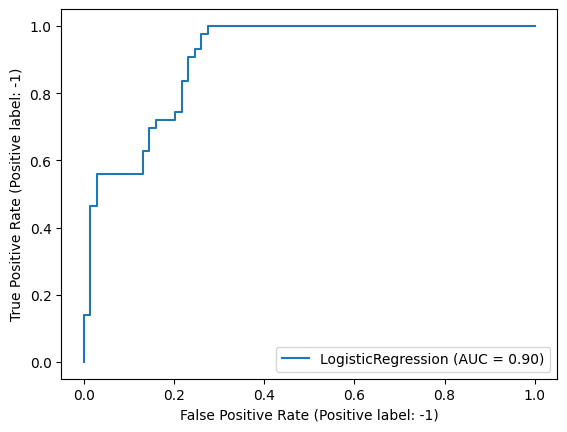

In [ ]:
plot_roc_curve(logistic_reg, xtest[predictors], ytest)

_Random Forest Performance_

In [ ]:
print_report(rforest, xtest[predictors], ytest)

              precision    recall  f1-score   support

          -1       0.70      0.70      0.70        43
           1       0.81      0.81      0.81        69

    accuracy                           0.77       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.77      0.77      0.77       112



ROC_AUC_Score: 0.8541


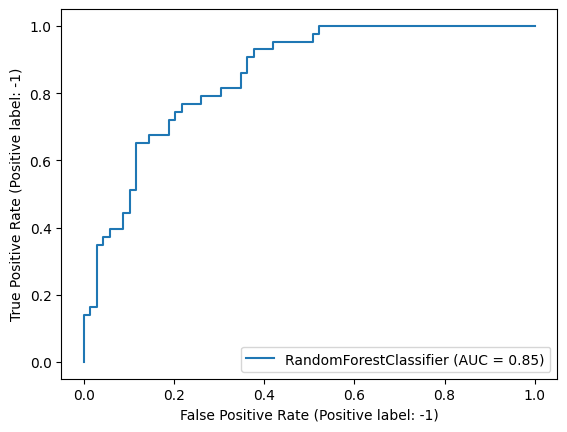

In [ ]:
plot_roc_curve(rforest, xtest[predictors], ytest)

- From the classification report, logistic regression model performs slightly better than the random forest model, with an AUC score of 0.9043 against an AUC score of 0.8541 for random forests.

- For random forests, 70% of instances that belong to the minority class (-1) were correctly predicted by the model, while 81% were correctly classified by logistic regression model. Also, 81% of the majority class (1) were correctly detected by the random forest classifier which is about 3% better than logistic regression model with a recall score of 78%. These translate that for the random forest model, 30% of the observations in the minority class were incorrectly classified to belong to the majority class while about 19% of the majority class were incorrectly predicted to belong to the minority class. For logistic regression model, it is 19% and 22% error rate respectively.

- Overall, the accuracies of both random forest and logistic regression models were 77% and 79% respectively, with average error rates between 21% and 23%

In [ ]:
# deleting to free memory
del train, X, y, train_pca, xtrain, ytrain, xtest, ytest

In [ ]:
# free more memory
gc.collect()

88300

---

# **Task 2**

In this section, I will repeat the above analysis by using a training dataset with observations greater than the one used above. 

In [ ]:
# load dataset
train = pd.read_csv('df_training_level3.csv')

<ipython-input-70-89ab82ee9c63>:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('df_training_level3.csv')


In [ ]:
train.shape

(72663, 1294)

In [ ]:
train.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,NP_775663.1:2,11072,NP_775663.1,2,T,8725101,64601,9606,2,1,...,0.235874,-0.186116,-0.007055,0.227716,-1.469320,0.024950,0.054577,0.142123,0.194421,0.471760
1,NP_775663.1:2,11072,NP_775663.1,3,K,8725101,64601,9606,2,1,...,0.014759,-0.119949,-0.016030,0.040704,-1.614884,0.189634,-0.049600,0.005898,0.128652,0.254778
2,NP_775663.1:2,11072,NP_775663.1,4,K,8725101,64601,9606,2,1,...,0.066743,-0.165863,-0.061832,0.026400,-1.353973,0.140752,-0.168214,0.114217,-0.002818,0.247916
3,NP_775663.1:2,11072,NP_775663.1,5,P,8725101,64601,9606,2,1,...,-0.148641,-0.088860,-0.218482,0.103855,-1.252338,-0.000789,0.049453,0.197773,0.034994,0.303203
4,NP_775663.1:2,11072,NP_775663.1,6,G,8725101,64601,9606,2,1,...,0.251960,-0.122903,-0.191698,0.142125,-0.985092,0.029431,0.176924,0.302354,-0.138180,0.136602


In [ ]:
# converting variable names to lower case and remove spaces in between names
train.columns = train.columns.str.lower().str.replace('\s+', '_', regex=True)

In [ ]:
check_data_types(train)

float64    1280
object       10
int64         4
dtype: int64


There are 1280 variables with missing values and 2642 duplicate rows in the train dataset.


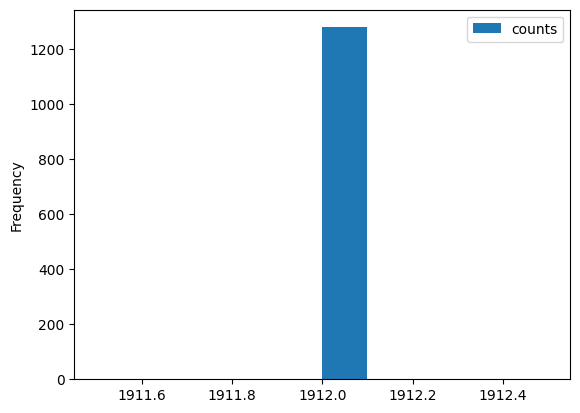

In [ ]:
checking_missing_values(train.filter(like='feat'), 'train')

- All the variables have missing values in them, each having about 1912 missing rows
- There are also duplicate rows in the train data

- These will be dropped in the preprocessing part. 

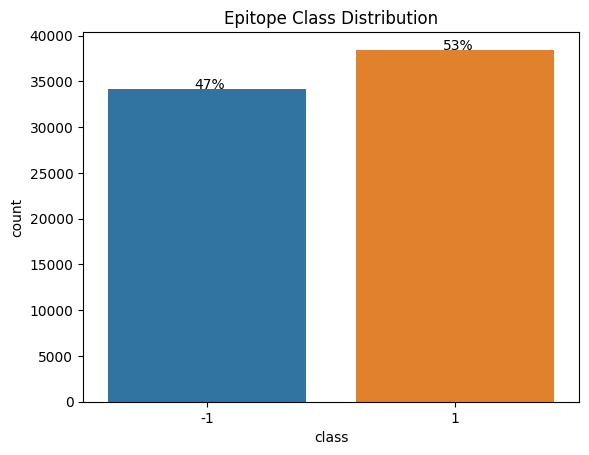

In [ ]:
# class distribution
ax = sns.countplot(x='class', data=train)
plt.title('Epitope Class Distribution')

for i in ax.patches:
  perc = i.get_height()/len(train)*100
  plt.text(i.get_x()+0.35, i.get_height()+0.3, f'{perc:.0f}%')
plt.show()

- Presence of slight class imbalance. 47% for minority class and 53% for majority class

In [ ]:
# get summary statistics
get_summary_statistics(train.filter(like='feat'))

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,...,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000,70751.000000
mean,0.024815,0.173018,0.113880,0.027288,-0.082433,-0.123585,-0.105387,-0.034119,-0.157909,-0.088024,...,0.196615,-0.079582,-0.139458,0.044415,-0.847064,-0.063032,0.073024,-0.014524,0.046024,0.172719
std,0.174920,0.176281,0.181818,0.158430,0.160356,0.186805,0.177181,0.222676,0.185068,0.170760,...,0.199385,0.178071,0.185102,0.178919,0.523521,0.204749,0.186501,0.177808,0.210502,0.229217
min,-0.971916,-0.904106,-0.910500,-1.007923,-0.886783,-1.206752,-1.256894,-1.147722,-1.495616,-1.196485,...,-0.690764,-1.082297,-1.092095,-0.993062,-2.195828,-0.720878,-0.818839,-1.136675,-1.155765,-1.470563
25%,-0.081343,0.067374,-0.005635,-0.065599,-0.184767,-0.242151,-0.214552,-0.189494,-0.254225,-0.185460,...,0.069401,-0.191774,-0.241258,-0.059300,-1.198041,-0.196620,-0.053293,-0.102688,-0.070784,0.076882
50%,0.034574,0.172033,0.110035,0.033116,-0.084928,-0.122892,-0.102315,-0.047335,-0.149543,-0.073290,...,0.171464,-0.081251,-0.126713,0.055421,-0.940723,-0.083454,0.060956,0.007127,0.067371,0.205800
75%,0.141719,0.273446,0.229405,0.128856,0.018662,-0.006256,0.009932,0.119599,-0.048052,0.025838,...,0.287886,0.027053,-0.016749,0.160118,-0.610000,0.037809,0.183790,0.100678,0.187270,0.313568
max,0.933674,1.169529,1.206786,0.947781,0.811858,0.860858,0.771866,1.449602,0.738278,0.664098,...,1.591888,0.902052,0.658360,0.938820,1.748948,1.177836,1.046847,0.682939,0.893074,0.971958
skewness,-0.387981,0.193781,0.090272,-0.384373,0.070677,0.096137,-0.252944,0.208631,-0.680672,-0.655016,...,1.268643,0.171863,-0.626755,-0.406838,1.159500,0.903363,0.469093,-0.866875,-0.667644,-1.329682
kurtosis,0.867033,1.761009,0.558410,1.708505,1.045350,1.196991,1.184692,0.838279,3.133239,1.678767,...,3.674023,1.302038,1.245149,1.462677,1.932418,1.890637,0.818863,1.868332,1.010160,3.503512


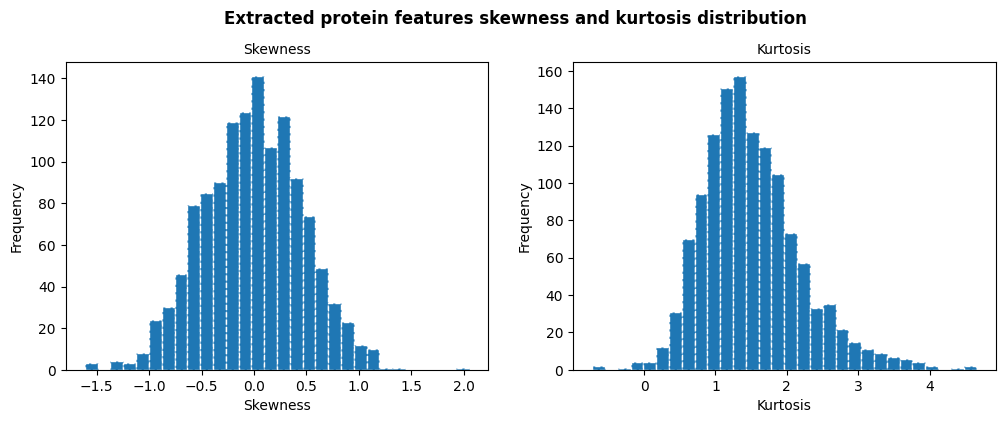

In [ ]:
# checking for skewness and kurtosis of data
check_distribution(train.filter(like='feat'))

- There's a mixture of positively, negatively and normally skewed variables
- There is also a potential presence of outliers in the datasets

In [ ]:
check_outliers(train.filter(like='feat'))

There are 1279 variables with outliers in the dataset.
31453 rows will be removed as outliers


- 1279 variables have outliers in them and if the outliers will be removed, almost half of the dataset (31,453) will be removed. Hence, instead of removing the outliers, they will be replaced using the lower and upper bound limits of a ZScore value.

100%|██████████| 1280/1280 [00:08<00:00, 143.16it/s]


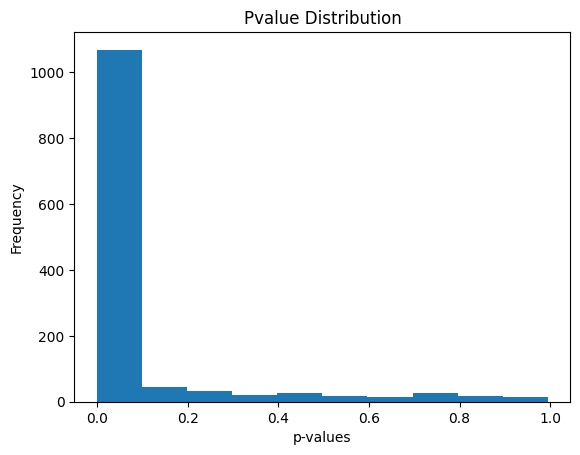

In [ ]:
# Calculate T-test
result = calc_ttest(train)

# plot distribution
result.pvalues.plot.hist(title='Pvalue Distribution')
plt.xlabel('p-values');

In [ ]:
# how many features are statistically significant?
result[result.pvalues <= 0.05].shape

(1030, 2)

- 1030 features are statistically significant
- Using these features will increase the time complexity, hence we will apply PCA to extract new features.

__Data Preprocessing__

- Dropping missing rows and duplicate rows
- Replace outliers and perform feature selection methods (PCA)

In [ ]:
# dropping missing rows and duplicate rows
train = train.dropna()
train = train.drop_duplicates().reset_index(drop=True)

In [ ]:
print(f'After dropping missing rows and duplicate rows, the dataset contains {train.shape[0]:,} observations')

After dropping missing rows and duplicate rows, the dataset contains 70,751 observations


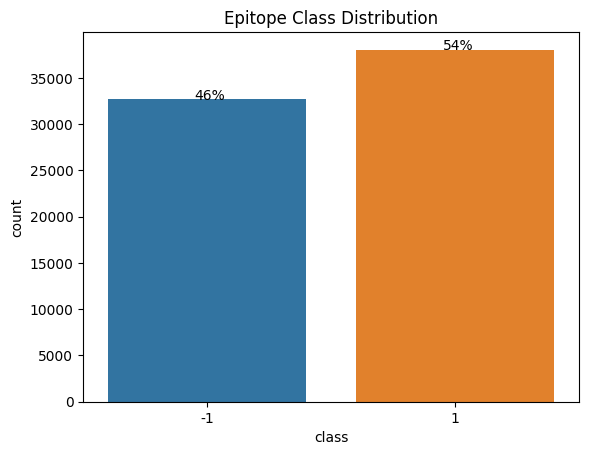

In [ ]:
# class distribution
ax = sns.countplot(x='class', data=train)
plt.title('Epitope Class Distribution')

for i in ax.patches:
  perc = i.get_height()/len(train)*100
  plt.text(i.get_x()+0.35, i.get_height()+0.3, f'{perc:.0f}%')
plt.show()

- Class imbalance also after dropping duplicate or missing rows

In [ ]:
# free memory from data importation
gc.collect()

13501

In [ ]:
# check the number of instances in each cluster belonging to minority and majority classes
train.groupby(['class', 'info_cluster'])['class'].count().unstack()

info_cluster,8,28,34,35,36,44,50,62,150,198,...,222,225,229,232,256,264,298,320,489,587
class,,,,,,,,,,,,,,,,,,,,,
-1,17738.0,11199.0,1083.0,1513.0,183.0,27.0,NaN,186.0,283.0,12.0,...,NaN,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28233.0,8150.0,62.0,110.0,61.0,NaN,87.0,338.0,281.0,31.0,...,15.0,58.0,54.0,45.0,7.0,8.0,69.0,42.0,20.0,50.0


In [ ]:
# scaling and treating outliers
train_scaled2 = preprocess_data(train)

100%|██████████| 1280/1280 [00:01<00:00, 1041.23it/s]


In [ ]:
# Feature reduction
train_pca = pca_feature_reduction(train_scaled2, var_ratio=0.95)

In [ ]:
train_pca.shape

(70751, 731)

In [ ]:
train_pca.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC722,PC723,PC724,PC725,PC726,PC727,PC728,PC729,info_cluster,class
0,-4.906565,-7.365773,14.497688,4.661384,1.950050,4.033003,3.297706,-3.393285,9.445981,0.431215,...,1.150821,0.667851,0.366331,-0.132372,0.490537,-0.535320,-0.101370,-0.322965,8,1
1,-5.642870,1.159707,0.457597,0.486647,-2.535716,-0.985023,7.648483,0.964663,7.299419,2.958772,...,0.012914,-0.314795,-0.191660,0.016610,-0.321295,-0.423511,-0.074186,-0.707358,8,1


- 729 principal components explain 95% of the variability in the data

In [ ]:
# pca features
predictors = train_pca.filter(like='PC').columns

In [ ]:
# separating into independent and target variables
X = train_pca.drop('class', axis=1)
y = train_pca['class']

In [ ]:
# pseudorandom seed for reproducibility
seed = 42

In [ ]:
# splitting data into train and test sets
# splitting will be done in a stratified method using the info_cluster
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=X['info_cluster'])

In [ ]:
xtrain.shape, xtest.shape

((56600, 730), (14151, 730))

In [ ]:
# getting the majority and minority class ratio in train data
ytrain.value_counts()

 1    30449
-1    26151
Name: class, dtype: int64

In [ ]:
# instantiating models
logistic_reg2 = LogisticRegression(random_state=seed, max_iter=500, class_weight={-1:0.6, 1:0.4})

rforest2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=35, min_samples_split=5, 
                                  n_estimators=400, n_jobs=7,random_state=seed)

In [ ]:
logistic_reg2.fit(xtrain[predictors], ytrain)

LogisticRegression(class_weight={-1: 0.6, 1: 0.4}, max_iter=500,
                   random_state=42)

In [ ]:
rforest2.fit(xtrain[predictors], ytrain)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=35,
                       min_samples_split=5, n_estimators=400, n_jobs=7,
                       random_state=42)

__Model Assessment__

_Logistic Regression Performance_

In [ ]:
print_report(logistic_reg2, xtest[predictors], ytest)

              precision    recall  f1-score   support

          -1       0.59      0.74      0.66      6544
           1       0.72      0.57      0.63      7607

    accuracy                           0.65     14151
   macro avg       0.66      0.65      0.65     14151
weighted avg       0.66      0.65      0.65     14151



ROC_AUC_Score: 0.7185


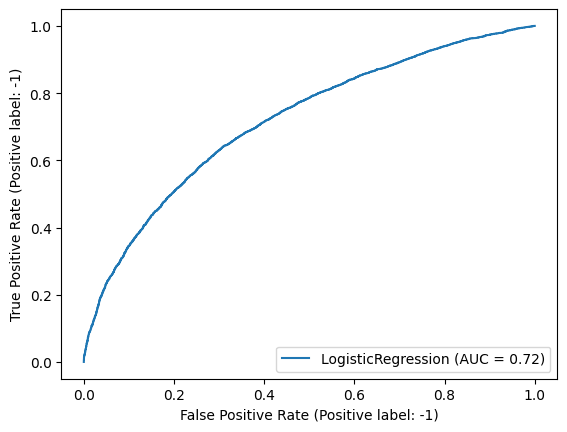

In [ ]:
plot_roc_curve(logistic_reg2, xtest[predictors], ytest)

__Random Forest__

In [ ]:
print_report(rforest2, xtest[predictors], ytest)

              precision    recall  f1-score   support

          -1       0.65      0.63      0.64      6544
           1       0.69      0.71      0.70      7607

    accuracy                           0.67     14151
   macro avg       0.67      0.67      0.67     14151
weighted avg       0.67      0.67      0.67     14151



ROC_AUC_Score: 0.7258


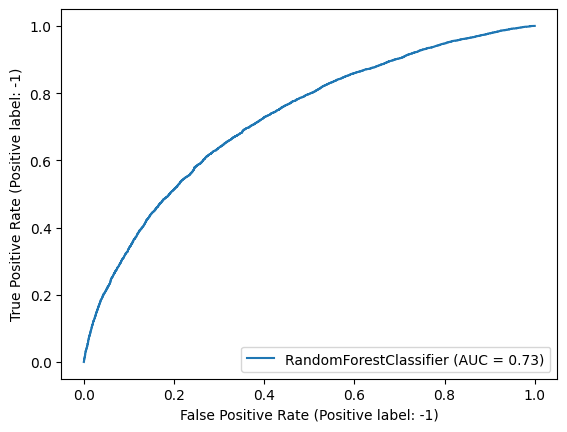

In [ ]:
plot_roc_curve(rforest2, xtest[predictors], ytest)

- AUC for random forest is slightly better than the AUC for logistic regression.
- Logistic regression model is better at detecting the negative class (74%) than random forest model which had aboiut 63% of the minority class correctly classified.
- On the other hand, random forest model performs better at predicting the majority class (71% of them were correctly predicted) against 59% by logistic regression model
- Overall performance, based on the accuracy, random forest model also performed slightly better with an accuracy of 67% while logistic regression model had an accuracy of 65% on the test dataset.

In [ ]:
gc.collect()

7041

## **Prediction on Hold out data**

From the methods above, the Logistic Regression model for the smaller dataset had the best in performance (AUC), and therefore will be selected. 

To do this, the hold out data will be preprocessed as it was done in Task 1. The preprocessing step to be done here would be to scale, and treat the outliers that may be present and then transform the scaled holdout data by extracting the number of principal components (215) obtained (the _train_scaled_ object will be used to do this).

In [ ]:
holdout_scaled = preprocess_data(holdout)

100%|██████████| 1280/1280 [00:00<00:00, 1344.27it/s]


In [ ]:
train_scaled.shape

(746, 1282)

In [ ]:
train_pca, holdout_pca = pca_feature_reduction(train_scaled, holdout_scaled, var_ratio=0.95) # train_scaled from task1

In [ ]:
predictors = train_pca.filter(like='PC').columns

# separating into independent and target variables
X = train_pca.drop('class', axis=1)
y = train_pca['class']

In [ ]:
# fitting on whole dataset and predicting on hold out data
logistic_reg.fit(X[predictors], y)

predictions = logistic_reg.predict(holdout_pca[predictors])

In [ ]:
# putting in a dataframe and saving
predictions = pd.DataFrame({'Class' : predictions})
predictions['Info_PepID'] = holdout.info_pepid
predictions['Info_pos'] = holdout.info_pos

# rearrange
predictions = predictions[['Info_PepID', 'Info_pos', 'Class']]

# save
predictions.to_csv('holdout_predictions.csv', index=False)

In [ ]:
predictions

,Info_PepID,Info_pos,Class
0,P09592.2:2,335,1
1,P09592.2:2,336,-1
2,P09592.2:2,337,1
3,P09592.2:2,338,1
4,P09592.2:2,339,-1
...,...,...,...
2036,NP_819008.1:2,91,1
2037,NP_819008.1:2,92,-1
2038,NP_819008.1:2,93,1
2039,NP_819008.1:2,94,-1


## **Conclusion**

Here, two machine learning models were fit on two datasets: a smaller epitope protein dataset _df_training_level1.csv_ and a larger dataset _df_training_level3.csv_. Data exploration and preprocessing steps were performed to explore and prepare the dataset for modelling and to ensure the accuracy of the results. From exploration, the datasets were found to contain missing values, duplicate rows, and the presence of outliers. For the smaller training data, no missing value or duplicate rows were found while for the larger dataset, the missing rows and duplicate rows were dropped. Variables were scaled using the ZScore method, with values within -3 and +3 range. For outlier treatment, values below -3 and above +3, were trimmed to either -3 or 3.

Two machine learning models: logistic regression and random forest models were fit on the smaller and larger datasets which were split into train and test datasets using the _info_cluster_ group to avoid data leakage. From the result, logistic regression model obtained a 90% AUC score on the smaller dataset, while the random forest model had AUC score of about 85%. On the larger dataset, the random forest model had a better AUC score than the logistic regression model, with 73% and 72% AUC values respectively.

The poor performance of the random forest model on the smaller dataset could as a result of the epitope observations in the dataset, however the poor performance of both models for the larger dataset could be because the data contains epitopes that are both closely and distantly related to Alphaviruses (target virus). Another could be because the epitopes in each epitope cluster are differentially distributed with observations in one info cluster more than the others in one target class and observations in some others not present in the other class. Increasing the number of observations in each cluster could improve the performance. Also, other feature selection techniques could be applied to find features with better predictive power.

In conclusion, machine learning techniques provide a promising approach to predicting epitopes of the Alphavirus genus. From our results, it was seen that the ability of a machine learning model to predict the probability of an epitope of closely or distantly related Alphavirus genus, given by the AUC scores, has a wide range of 72% and 90%. This opens a new window of quickly detecting and characterising new and unseen epitopes of different allergies, some cancers and infectious diseases.

In [2]:
!jupyter nbconvert /content/CS4850_Data_Mining.ipynb --to html

[NbConvertApp] Converting notebook /content/CS4850_Data_Mining.ipynb to html
[NbConvertApp] Writing 1659010 bytes to /content/CS4850_Data_Mining.html
